#**Optical Flow Estimation**

#**Mount Drive**


In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/2022 한국컴퓨터비전학회 프로그래밍/TA_session')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import necessary libraries**

In [2]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import glob
from tqdm import tqdm
from torch.nn.init import kaiming_normal_, constant_
import torch.nn as nn
import torchvision.transforms as transforms
from imageio import imread, imwrite
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# **Use KITTI Dataset**

In [3]:
class Kitti_flow_dataset(Dataset):
    def __init__(self, root):
        self.root = root
        flow_prefix = 'flow_occ'
        left_image_prefix = 'image_2'
        self.flow_dir = os.path.join(root, flow_prefix)
        self.image_dir = os.path.join(root, left_image_prefix)
        self.flow_list = sorted(os.listdir(self.flow_dir))
        self.image1_list = [flow_file.replace('flow_occ', left_image_prefix) for flow_file in self.flow_list]
        self.image2_list = [image1_file.replace('_10', '_11') for image1_file in self.image1_list]
    
    def __getitem__(self, index):
        image1 = imread(os.path.join(self.image_dir, self.image1_list[index]))
        image2 = imread(os.path.join(self.image_dir, self.image2_list[index]))
        flow = imread(os.path.join(self.flow_dir, self.flow_list[index]))
        return image1, image2, flow

    def __len__(self):
        return len(self.path_list)

# **Show some example of KITTI dataset**

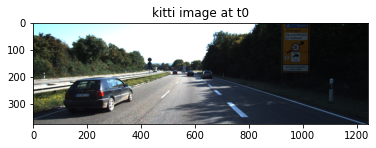

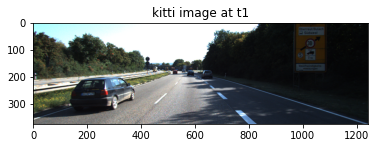

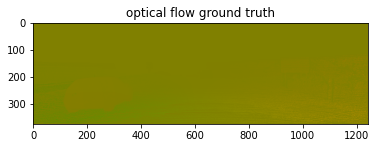

In [8]:
base_path = '/content/drive/MyDrive/2022 한국컴퓨터비전학회 프로그래밍/TA_session/'
kitti_prefix = 'KITTI2015'
kitti_flow_datapath = os.path.join(base_path, kitti_prefix)
kitti_dataset = Kitti_flow_dataset(kitti_flow_datapath)

image1, image2, flow = kitti_dataset.__getitem__(100)

plt.figure()
plt.title('kitti image at t0')
plt.imshow(image1)
plt.show()

plt.figure()
plt.title('kitti image at t1')
plt.imshow(image2)
plt.show()

plt.figure()
plt.title('optical flow ground truth')
plt.imshow(flow)
plt.show()

# **Data Transform**

In [9]:
class ArrayToTensor(object):
    """Converts a numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)."""

    def __call__(self, array):
        assert(isinstance(array, np.ndarray))
        array = np.transpose(array, (2, 0, 1))
        # handle numpy array
        tensor = torch.from_numpy(array)
        # put it from HWC to CHW format
        return tensor.float()

# **Submodules for convolution neural network**

In [10]:
def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )

def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)

def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )

def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

# **Network architecture of FlowNetS**

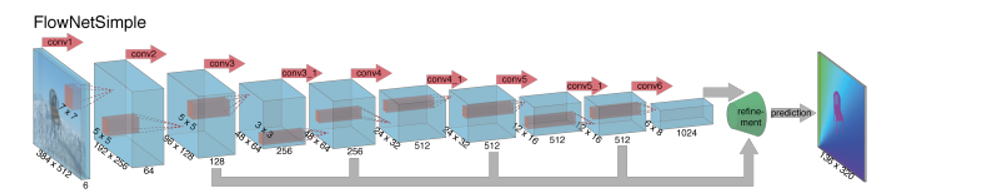

## Refinement layer

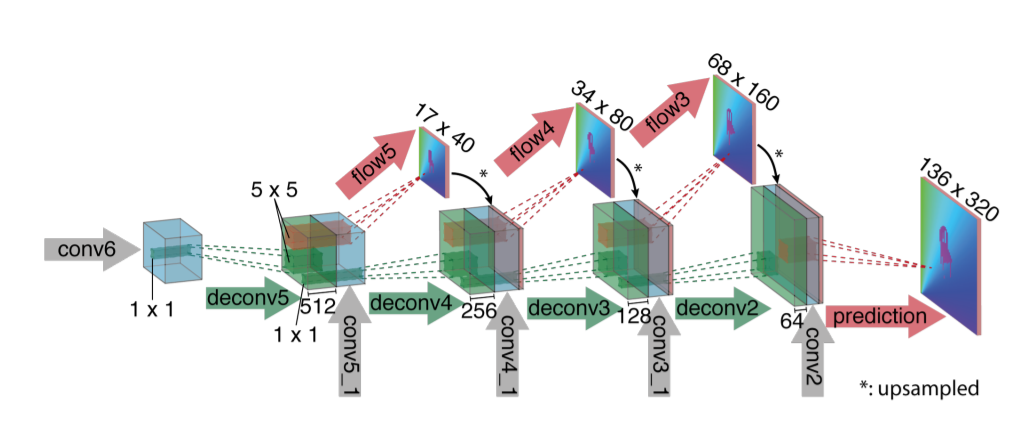

In [13]:
class FlowNetS(nn.Module):
    expansion = 1
    def __init__(self,batchNorm=True):
        super(FlowNetS,self).__init__()
        self.batchNorm = batchNorm
        # step 1
        ### fine this None part ###
        self.conv1   = conv(self.batchNorm, 6,  64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm, 64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm, 1024, 1024)

        # step 2
        ### fill this part ###
        x1 = 1024
        x2 = 1026
        x3 = 512 + 256 + 2
        x4 = 386
        self.deconv5 = deconv(x1,512)
        self.deconv4 = deconv(x2,256)
        self.deconv3 = deconv(x3,128)
        self.deconv2 = deconv(x4,64)

        # step 3
        ### fill this part ###
        x5 = 1024
        x6 = 1026
        x7 = 770
        x8 = 386
        x9 = 194
        self.predict_flow6 = predict_flow(x5)
        self.predict_flow5 = predict_flow(x6)
        self.predict_flow4 = predict_flow(x7)
        self.predict_flow3 = predict_flow(x8)
        self.predict_flow2 = predict_flow(x9)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]


def flownets_bn(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)

    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=True)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model

#**Import custom images**

In [14]:
# any number 0~200
image_num = 46 
image_left_prefix = 'image_2'

img_dir = os.path.join(kitti_flow_datapath, image_left_prefix)

img_t0_name = os.path.join(img_dir, str(image_num).zfill(6) + '_10.png')
img_t1_name = os.path.join(img_dir, str(image_num).zfill(6) + '_11.png')

img_t0 = imread(img_t0_name)
img_t1 = imread(img_t1_name)


input_transform = transforms.Compose([
    ArrayToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
    transforms.Normalize(mean=[0.411,0.432,0.45], std=[1,1,1])
])


img1 = input_transform(img_t0)
img2 = input_transform(img_t1)
input_var = torch.cat([img1, img2]).unsqueeze(0)

# create model
flownet_ckpt_name = 'flownets_bn_EPE2.459.pth.tar'
pretrained_model = os.path.join(base_path, 'Pretrained', flownet_ckpt_name)
checkpoint = torch.load(pretrained_model)
print("=> using pre-trained model '{}'".format(checkpoint['arch']))

model = flownets_bn(checkpoint).to(device)
model.eval()
cudnn.benchmark = True

bidirectional = True
if bidirectional:
    # feed inverted pair along with normal pair
    inverted_input_var = torch.cat([img2, img1]).unsqueeze(0)
    input_var = torch.cat([input_var, inverted_input_var])

input_var = input_var.to(device)
# compute output
flow_output = model(input_var)

=> using pre-trained model 'flownets_bn'


#**Print model architecture summary**

In [15]:
print(model)

FlowNetS(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Leaky

#**Optical flow visualization**

In [16]:
def flow2rgb(flow_map, max_value):
    flow_map_np = flow_map.detach().cpu().numpy()
    _, h, w = flow_map_np.shape
    flow_map_np[:,(flow_map_np[0] == 0) & (flow_map_np[1] == 0)] = float('nan')
    rgb_map = np.ones((3,h,w)).astype(np.float32)
    if max_value is not None:
        normalized_flow_map = flow_map_np / max_value
    else:
        normalized_flow_map = flow_map_np / (np.abs(flow_map_np).max())
    rgb_map[0] += normalized_flow_map[0]
    rgb_map[1] -= 0.5*(normalized_flow_map[0] + normalized_flow_map[1])
    rgb_map[2] += normalized_flow_map[1]
    return rgb_map.clip(0,1)

#**Optical flow estimation**

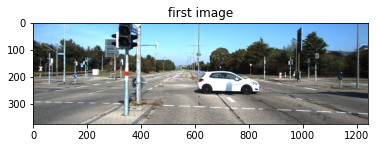

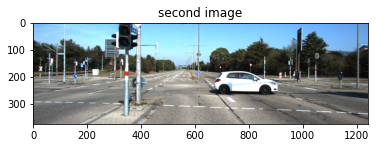

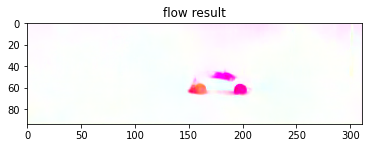

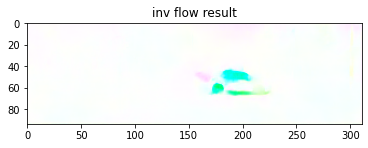

In [17]:
rgb_flow = flow2rgb(20 * flow_output[0], max_value=20)
rgb_inv_flow = flow2rgb(20 * flow_output[1], max_value=20)
rgb_flow_viz = (rgb_flow * 255).astype(np.uint8).transpose(1,2,0)
rgb_flow_inv_viz = (rgb_inv_flow * 255).astype(np.uint8).transpose(1,2,0)


plt.figure()
plt.title('first image')
plt.imshow(img_t0)

plt.figure()
plt.title('second image')
plt.imshow(img_t1)

plt.figure()
plt.title('flow result')
plt.imshow(rgb_flow_viz)

plt.figure()
plt.title('inv flow result')
plt.imshow(rgb_flow_inv_viz)
plt.show()